In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

new_columns = [
    "par_id",      # 1 (integer ID)
    "art_id",      # @@24942188 (article identifier)
    "topic",       # hopeless (PCL category)
    "country",     # ph (country code)
    "text",        # Full text content
    "label"        # 0 (binary label)
]

# Read main dataset - skip 4 disclaimer rows
df = pd.read_csv(
    "data/dontpatronizeme_pcl.tsv",
    sep="\t",
    header=None,
    skiprows=4,
    names=new_columns,
    on_bad_lines='warn'
)

longest_text_length = df['text'].str.len().max()
print(f"The length of the longest text is: {longest_text_length}")
# Find the length of the longest text in terms of words
longest_text_word_count = df['text'].str.split().str.len().max()
shortest_text_word_count = df['text'].str.split().str.len().argmin()
print(f"The length of the longest text in terms of words is: {longest_text_word_count}")
print(f"The length of the shortest text in terms of words is: {shortest_text_word_count}")


The length of the longest text is: 5493
The length of the longest text in terms of words is: 909
The length of the shortest text in terms of words is: 1656


## Preprocessing

In [2]:
# Read train/dev splits
train_val_labels = pd.read_csv("data/train_semeval_parids-labels.csv")
test_labels = pd.read_csv("data/dev_semeval_parids-labels.csv")

# Convert string labels to lists
def parse_labels(label_str: str) -> list[int]:
    return [int(x) for x in label_str.strip("[]").replace(" ", "").split(",")]

# Process labels dataframes
for labels_df in [train_val_labels, test_labels]:
    labels_df['labels'] = labels_df['label'].apply(parse_labels)
    labels_df.drop('label', axis=1, inplace=True)

# Join with main data
train_val_df = df.merge(train_val_labels, on="par_id", how="inner")
test_df = df.merge(test_labels, on="par_id", how="inner")

## Data distribution analysis

#### Analysis the label frequencies. Label contains category 0 to 4.


Train & Validation Set Label Distribution:
label
0    6825
1     756
2     126
3     369
4     299
Name: count, dtype: int64


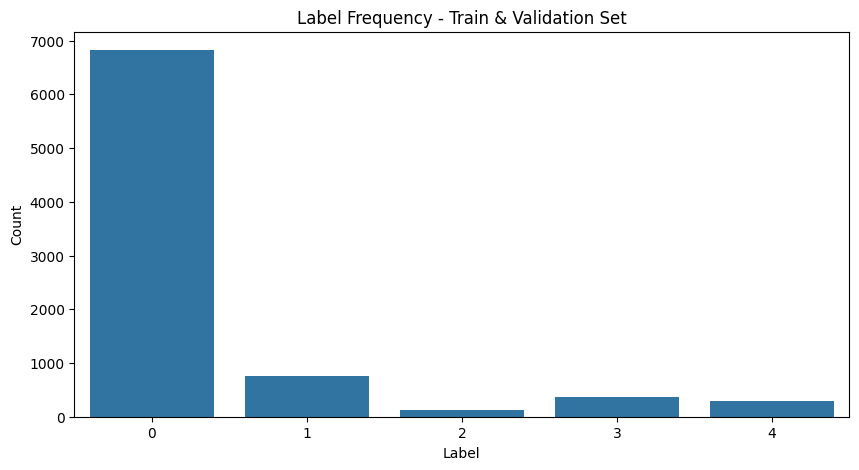


Test Set Label Distribution:
label
0    1703
1     191
2      18
3      89
4      92
Name: count, dtype: int64


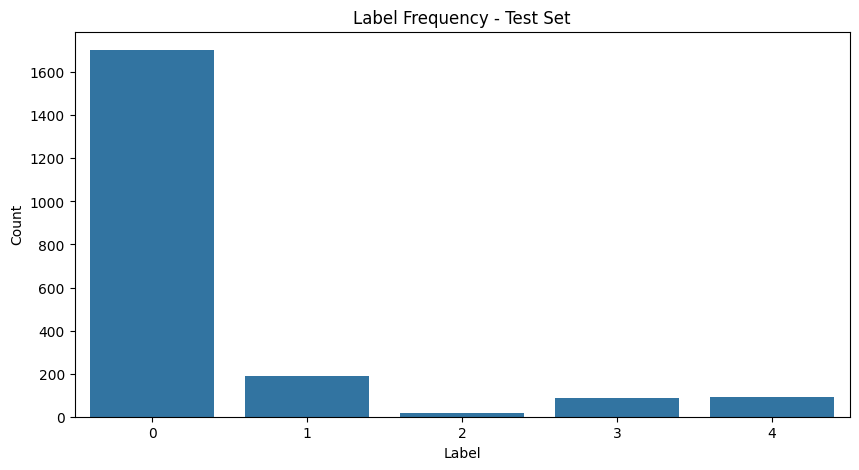

In [3]:
# Label frequency analysis
def analyze_labels(df, name):
    # Explode the list of labels into individual rows
    label_counts = df['label'].value_counts().sort_index()
    
    print(f"\n{name} Set Label Distribution:")
    print(label_counts)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_counts.index, y=label_counts.values)
    plt.title(f'Label Frequency - {name} Set')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

# Analyze all splits
for df, name in [(train_val_df, 'Train & Validation'), (test_df, 'Test')]:
    analyze_labels(df, name)


#### Process and analyze the frequency of PCL label grouping. 


Train & Validation Set PCL Group Distribution:
Negative PCL (0,1): 7581 (90.5%)
Positive PCL (2,3,4): 794 (9.5%)


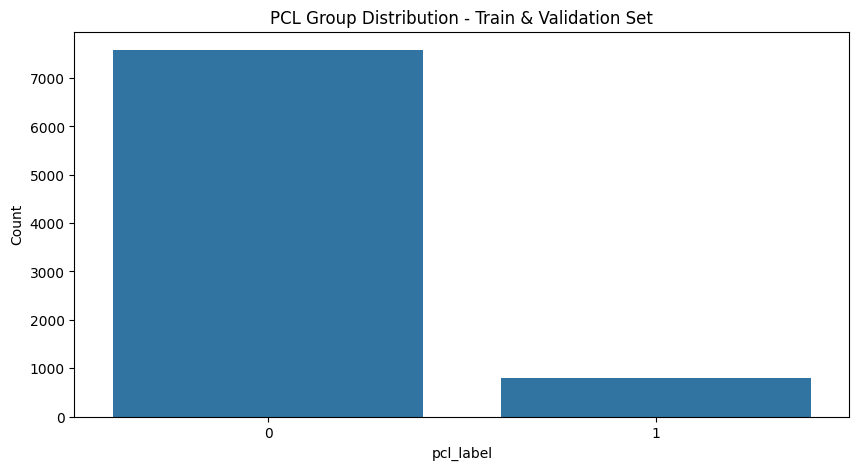


Test Set PCL Group Distribution:
Negative PCL (0,1): 1894 (90.5%)
Positive PCL (2,3,4): 199 (9.5%)


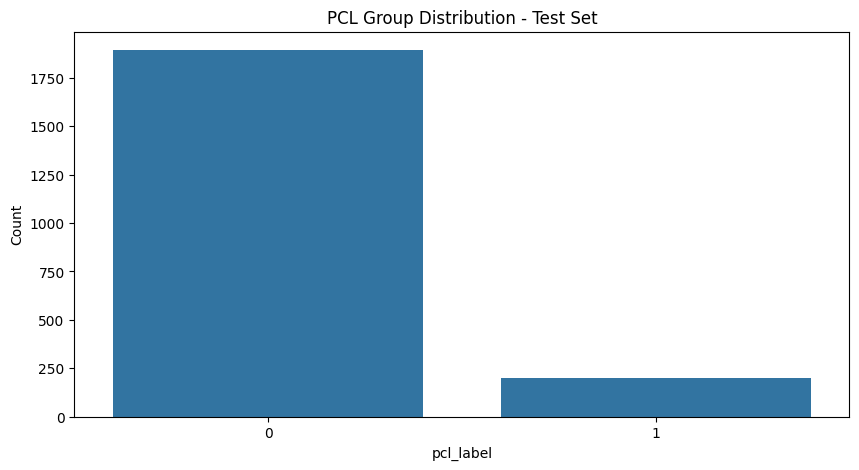

In [4]:

# Add PCL positivity column to both dataframes
train_val_df['pcl_label'] = train_val_df['label'].apply(
    lambda x: 0 if x in {0, 1} else 1)
test_df['pcl_label'] = test_df['label'].apply(
    lambda x: 0 if x in {0, 1} else 1)

# Analyze PCL label groupings
def analyze_pcl_groups(df, name):
    # Get counts from precomputed column
    counts = df['pcl_label'].value_counts()
    negative_pcl = counts.get(0, 0)
    positive_pcl = counts.get(1, 0)
    
    print(f"\n{name} Set PCL Group Distribution:")
    print(f"Negative PCL (0,1): {negative_pcl} ({negative_pcl/len(df):.1%})")
    print(f"Positive PCL (2,3,4): {positive_pcl} ({positive_pcl/len(df):.1%})")
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=counts.index, y=counts.values)
    plt.title(f'PCL Group Distribution - {name} Set')
    plt.ylabel('Count')
    plt.show()

# Analyze both splits
for df, name in [(train_val_df, 'Train & Validation'), (test_df, 'Test')]:
    analyze_pcl_groups(df, name)


#### Distribution of Length in correlation to PCL labelling

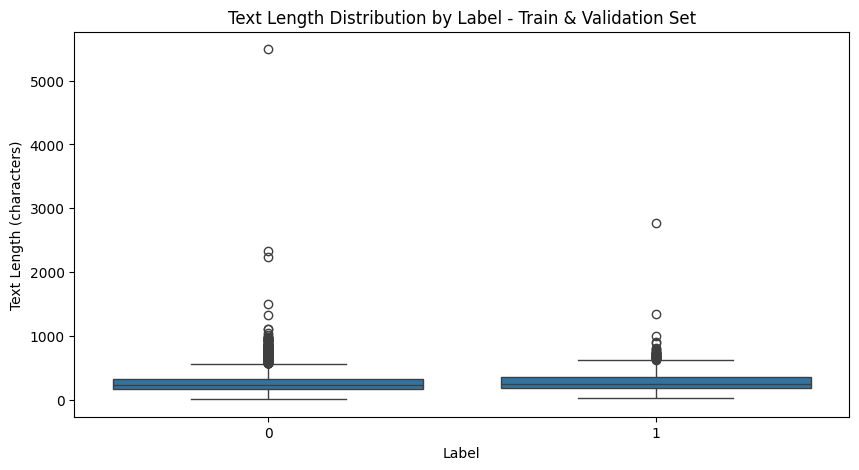

Train & Validation Set Text Length-Label Correlation: 0.037


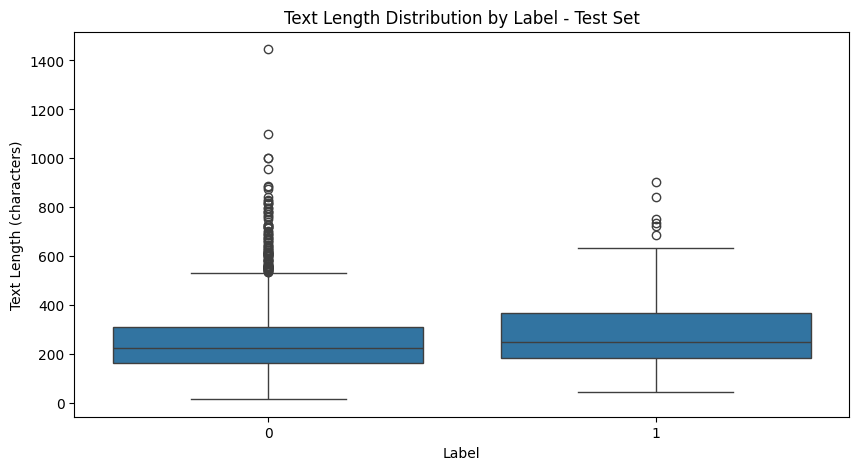

Test Set Text Length-Label Correlation: 0.062


In [5]:

# Add another cell for text length analysis
# Calculate text lengths
train_val_df['text_length'] = train_val_df['text'].str.len()
test_df['text_length'] = test_df['text'].str.len()

# Correlation between text length and labels
def analyze_length_correlation(df, name):
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df['pcl_label'], y='text_length', data=df)
    plt.title(f'Text Length Distribution by Label - {name} Set')
    plt.xlabel('Label')
    plt.ylabel('Text Length (characters)')
    plt.show()
    
    # Calculate correlation (convert label list to single value)
    correlation = df['text_length'].corr(df['pcl_label'])
    print(f"{name} Set Text Length-Label Correlation: {correlation:.3f}")

for df, name in [(train_val_df, 'Train & Validation'), (test_df, 'Test')]:
    analyze_length_correlation(df, name)

#### Anaylze the length correlation using point-biserail correlation analysis and stratified binning and point plot.

Train & Validation: Balanced Point-biserial: r=0.064 (p=0.0107)


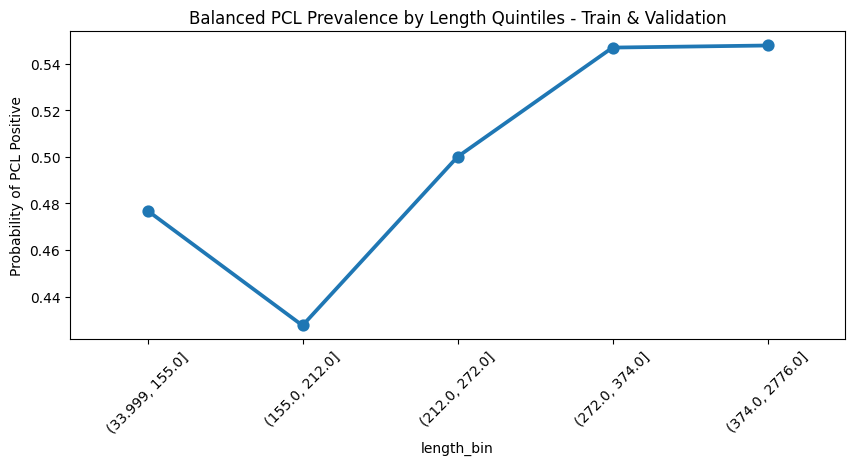

Test: Balanced Point-biserial: r=0.102 (p=0.0425)


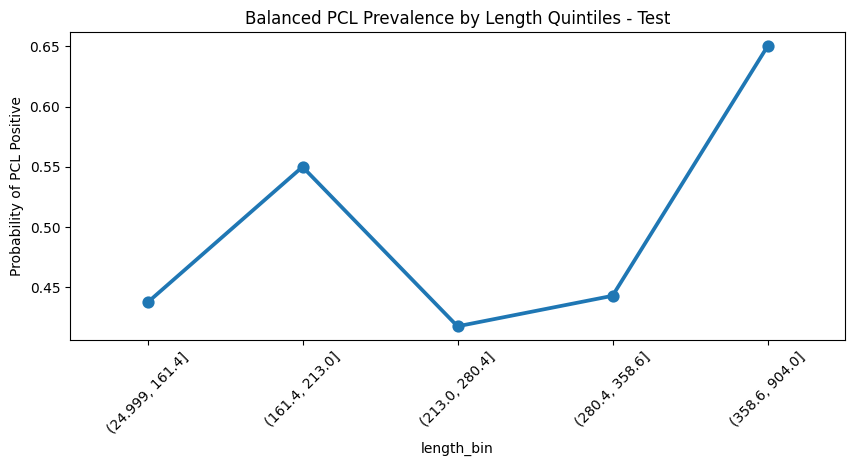

In [6]:
def analyze_length_correlation(df, name):
    from scipy.stats import pointbiserialr
    from sklearn.utils import resample
    
    # Balance samples using downsampling
    majority = df[df['pcl_label'] == 0]
    minority = df[df['pcl_label'] == 1]
    balanced_majority = resample(majority, 
                               n_samples=len(minority), 
                               replace=False,
                               random_state=42)
    balanced_df = pd.concat([balanced_majority, minority])

    # Point-biserial correlation analysis
    corr, p_corr = pointbiserialr(balanced_df['text_length'], 
                                balanced_df['pcl_label'])
    print(f"{name}: Balanced Point-biserial: r={corr:.3f} (p={p_corr:.4f})")

    # Stratified binning and point plot
    balanced_df['length_bin'] = pd.qcut(balanced_df['text_length'], q=5)
    bin_analysis = balanced_df.groupby('length_bin', observed=False)['pcl_label'].agg(['mean', 'count'])
    
    plt.figure(figsize=(10, 4))
    sns.pointplot(data=bin_analysis.reset_index(), x='length_bin', y='mean',
              errorbar=('ci', 95),
              linestyle='-',
              markers='o')
    plt.title(f'Balanced PCL Prevalence by Length Quintiles - {name}')
    plt.xticks(rotation=45)
    plt.ylabel('Probability of PCL Positive')
    plt.show()

for df, name in [(train_val_df, 'Train & Validation'), (test_df, 'Test')]:
    analyze_length_correlation(df, name)

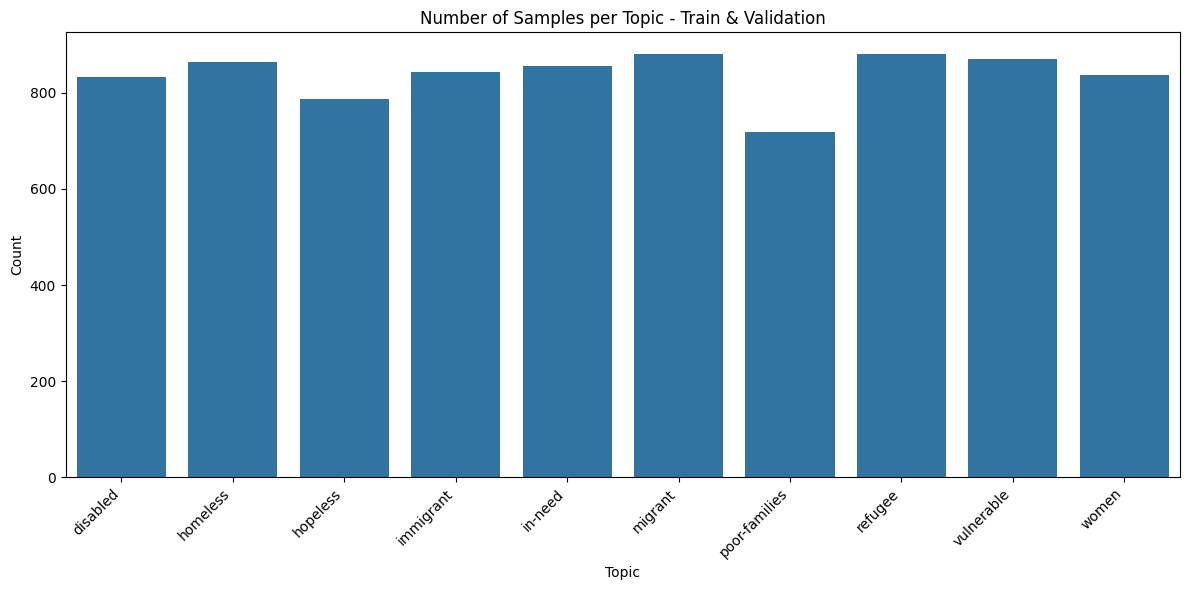

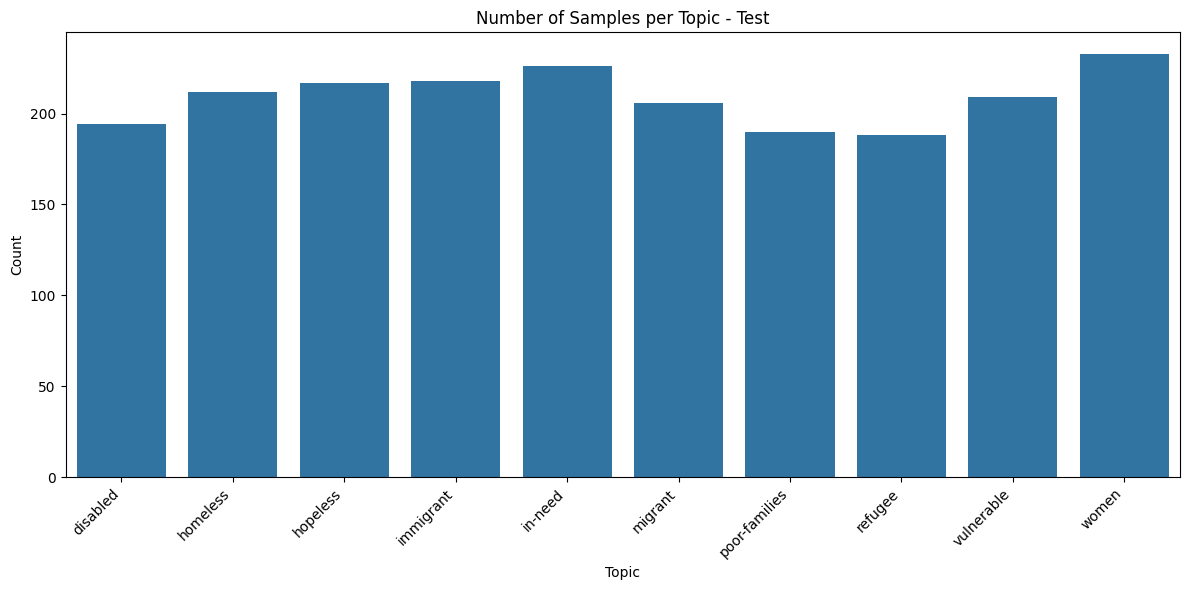

In [7]:
def plot_topic_distribution(df, name):
    plt.figure(figsize=(12, 6))
    topic_counts = df['topic'].value_counts().sort_index()
    sns.barplot(x=topic_counts.index, y=topic_counts.values)
    plt.title(f'Number of Samples per Topic - {name}')
    plt.xlabel('Topic')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Analyze both datasets
for df, name in [(train_val_df, 'Train & Validation'), (test_df, 'Test')]:
    plot_topic_distribution(df, name)


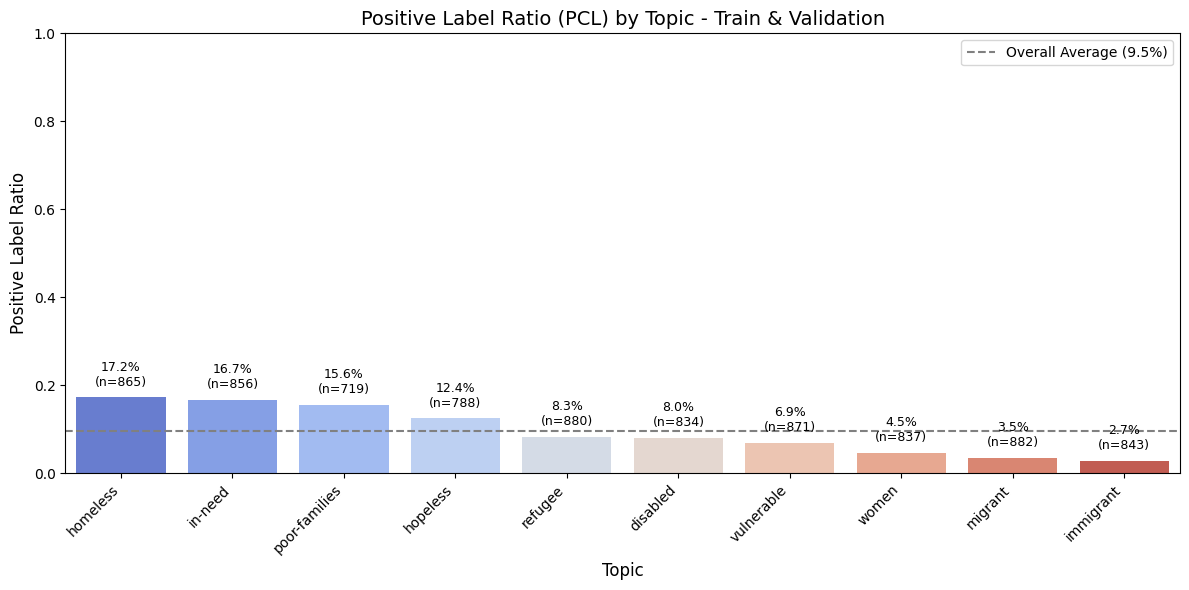

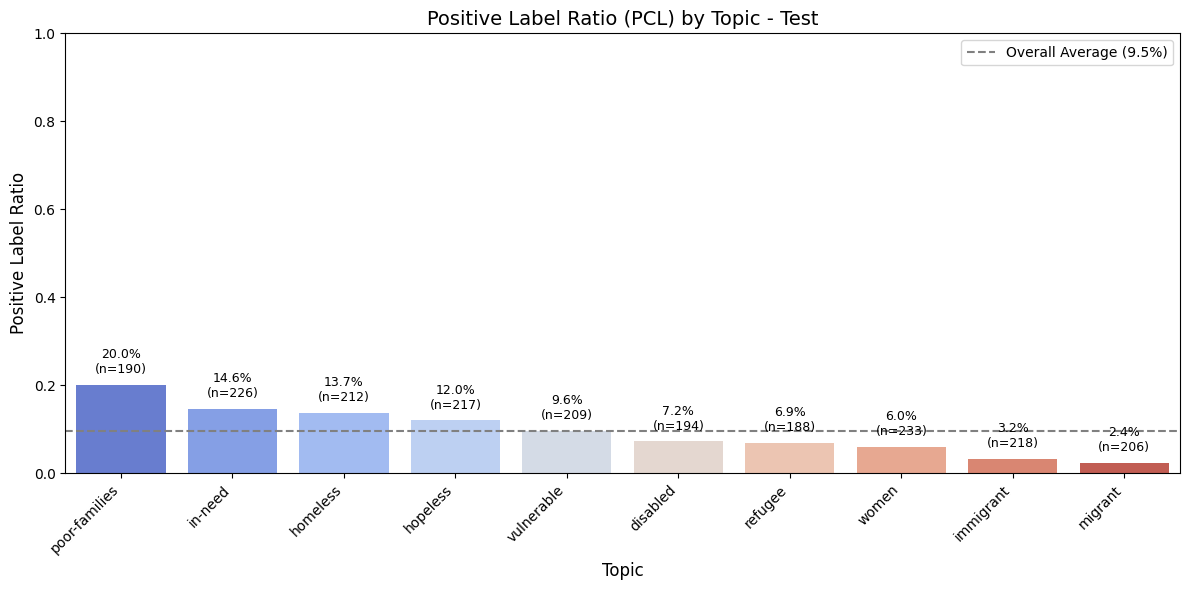

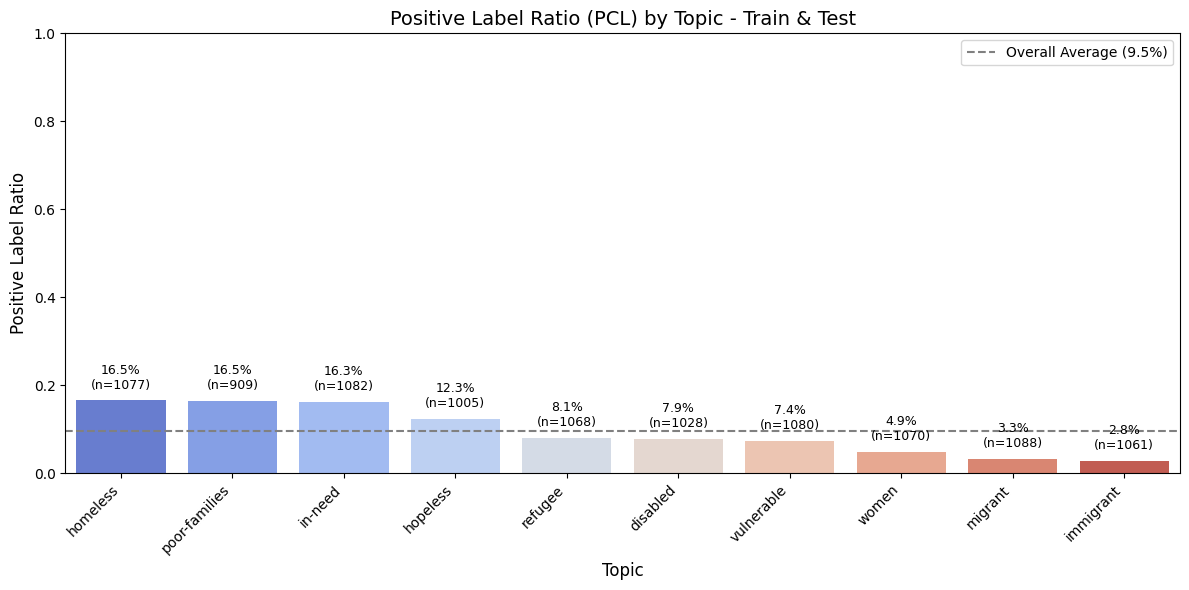

In [8]:
def plot_topic_ratios(df, name):
    # Calculate positive label ratio per topic
    topic_ratios = df.groupby('topic')['pcl_label'].agg(['mean', 'count'])
    topic_ratios = topic_ratios.sort_values('mean', ascending=False)

    # Plot ratio visualization
    plt.figure(figsize=(12, 6))
    sns.barplot(x=topic_ratios.index, 
                y=topic_ratios['mean'], 
                hue=topic_ratios.index,
                palette='coolwarm',
                legend=False)

    # Add annotations
    plt.axhline(y=df['pcl_label'].mean(), color='gray', linestyle='--', 
                label=f'Overall Average ({df["pcl_label"].mean():.1%})')
    plt.title(f'Positive Label Ratio (PCL) by Topic - {name}', fontsize=14)
    plt.xlabel('Topic', fontsize=12)
    plt.ylabel('Positive Label Ratio', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.legend()

    # Add percentage labels
    for i, (ratio, count) in enumerate(zip(topic_ratios['mean'], topic_ratios['count'])):
        plt.text(i, ratio + 0.02, f'{ratio:.1%}\n(n={count})', 
                 ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

# Analyze both datasets
for df, name in [(train_val_df, 'Train & Validation'), (test_df, 'Test')]:
    plot_topic_ratios(df, name)

plot_topic_ratios(pd.concat([train_val_df, test_df]), 'Train & Test')

# Qualitative Assessment

In [9]:
# Sample PCL and Non-PCL examples
pcl_samples = train_val_df[train_val_df["label"] == 1].sample(10, random_state=42)
non_pcl_samples = train_val_df[train_val_df["label"] == 0].sample(10, random_state=42)

print("PCL Examples:")
for idx, row in pcl_samples.iterrows():
    print(f"Text: {row['text']}\nCategory: {row['topic']}\n")

print("Non-PCL Examples:")
for idx, row in non_pcl_samples.iterrows():
    print(f"Text: {row['text']}\n")

PCL Examples:
Text: When I compare the plight of the homeless people of Sodom and Gomorrah to the warm reception given to the refugees from Liberia and Cote d'Ivoire , it clearly reveals the greed and wickedness of the government . Due to the money that is paid by the United Nations to the government of Ghana , the refugees are given accommodation and food while the homeless Ghanaians are treated with disdain . This is discrimination pure and simple . Lord , have mercy !
Category: homeless

Text: The MEPs expected that the draft ' Foreign Donations Act ' would guarantee " adequate space " for civil society organisations to continue working for the betterment of the situation of vulnerable populations .
Category: vulnerable

Text: The People 's Project , which has been very successful in addressing homelessness for rough sleepers in Hamilton , was established by the Wise Group . Last year , the group was invited by Our Community Project ( OCP ) to work together to design and develop a s

In [10]:
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, shuffle=True)
print(test_df[test_df['text'].isna()])

Empty DataFrame
Columns: [par_id, art_id, topic, country, text, label, labels, pcl_label, text_length]
Index: []


In [11]:
from models import BoWRegressor
from models import RandomClassifier
from sklearn.metrics import classification_report, f1_score
import torch

torch.manual_seed(42)

model = BoWRegressor()
model.fit(train_df['text'], train_df['pcl_label'])
y_pred = model(test_df['text'])
print(classification_report(test_df['pcl_label'], y_pred))
print("F1 Score:", f1_score(test_df['pcl_label'], y_pred, pos_label=1))


random_model = RandomClassifier()
y_pred = random_model(test_df['text'])
print(classification_report(test_df['pcl_label'], y_pred))
print("F1 Score:", f1_score(test_df['pcl_label'], y_pred, pos_label=1))


              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1894
           1       0.31      0.37      0.34       199

    accuracy                           0.86      2093
   macro avg       0.62      0.64      0.63      2093
weighted avg       0.87      0.86      0.87      2093

F1 Score: 0.33867276887871856
              precision    recall  f1-score   support

           0       0.91      0.51      0.65      1894
           1       0.10      0.51      0.16       199

    accuracy                           0.51      2093
   macro avg       0.50      0.51      0.41      2093
weighted avg       0.83      0.51      0.61      2093

F1 Score: 0.16462917685411574
